In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.datasets.dblp import DBLP
import random
import dgl
import torch
from torch import optim
import torch_geometric.utils.convert
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Train DBLP

In [3]:
 #https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_conv_dblp.py
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)


class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])


model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device =  'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)
Epoch: 010, Loss: 0.1663, Train: 0.9925, Val: 0.8025, Test: 0.8296
Epoch: 020, Loss: 0.0013, Train: 1.0000, Val: 0.8125, Test: 0.8287
Epoch: 030, Loss: 0.0026, Train: 1.0000, Val: 0.8075, Test: 0.8207
Epoch: 040, Loss: 0.0044, Train: 1.0000, Val: 0.8100, Test: 0.8136
Epoch: 050, Loss: 0.0045, Train: 1.0000, Val: 0.8025, Test: 0.8152
Epoch: 060, Loss: 0.0042, Train: 1.0000, Val: 0.7975, Test: 0.8170
Epoch: 070, Loss: 0.0039, Train: 1.0000, Val: 0.7975, Test: 0.816

Graph (without node features) generated from HGEN

In [5]:
G = nx.read_gexf("DBLP_four_area_hgen.gexf")

Adding node features to graph

importing Jupyter notebook from dblp_gmm_features.ipynb
no of class author0 node samples - 1150
no of class author1 node samples - 1150
no of class author2 node samples - 1150
no of class author3 node samples - 1151
no of class paper node samples - 2988
no of class term node samples - 3646


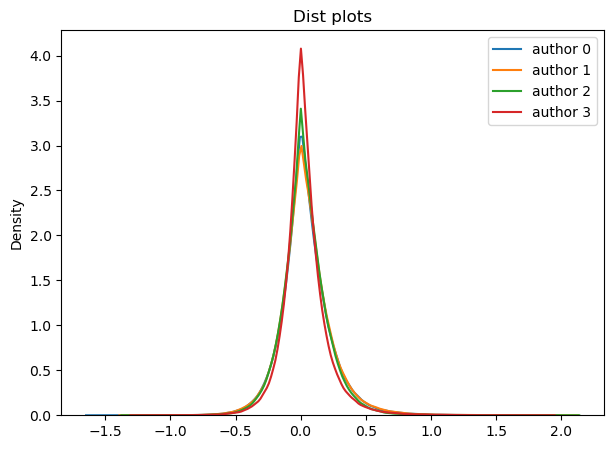

In [6]:
#Load node features 
import import_ipynb
import dblp_gmm_features

In [7]:
author_node_features = dblp_gmm_features.author_node_features
paper_node_features = dblp_gmm_features.paper_node_features
term_node_features = dblp_gmm_features.term_node_features
conf_nodes = dblp_gmm_features.conf_nodes

In [8]:
 #Adding node degree
for node in G.nodes():
    d = G.degree(node)
    G.nodes[node]["degree"] = d

In [9]:
#Generate graphs of 2-hop neighbourhood
def graph_gen(nodeid):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    if 3 <= len(nodes) <= 50:
        graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
        #Get small graph edges
        edges = [e for e in graph.edges]
        #nx.draw(graph, with_labels = True)
        #plt.show()
        #print('nodeid',nodeid)
        #print('node count',len(nodes))
        #print('edge count',len(edges))
        return nodes, edges
    else:
        return None, None

In [10]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [11]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [12]:
def get_node_type(node_id):
    if (int(node_id) in list(author_node_features['nodeId'])):
        return 'author'
    elif (int(node_id) in list(paper_node_features['nodeId'])):
        return 'paper'
    elif (int(node_id) in list(term_node_features['nodeId'])):
        return 'term'
    elif (int(node_id) in list(conf_nodes['nodeId'])):
        return 'conference'

In [13]:
all_edges = {}

In [14]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [15]:
def create_dataset(nodes,edges,author_node_features,paper_node_features,term_node_features,conf_nodes,node_id):
    
    author_df = author_node_features[author_node_features["nodeId"].isin([int(x) for x in nodes])]
    paper_df = paper_node_features[paper_node_features["nodeId"].isin([int(x) for x in nodes])]
    term_df = term_node_features[term_node_features["nodeId"].isin([int(x) for x in nodes])]
    conf_df = conf_nodes[conf_nodes["nodeId"].isin([int(x) for x in nodes])] 
    
    #Nodes   
    author = np.asarray(author_df.drop(columns=['nodeId','class']))
    paper = np.asarray(paper_df.drop(columns=['nodeId']))
    term = np.asarray(term_df.drop(columns=['nodeId']))
    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))
    
    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []
 
    for i in range(len(edges)):

        if (int(source[i]) in list(author_df['nodeId'])) and (int(dest[i]) in list(paper_df['nodeId'])):
            author_to_paper.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(paper_df['nodeId'])) and (int(dest[i]) in list(author_df['nodeId'])):
            paper_to_author.append((int(source[i]),int(dest[i]))) 

        elif (int(source[i]) in list(paper_df['nodeId'])) and (int(dest[i]) in list(term_df['nodeId'])):     
            paper_to_term.append((int(source[i]),int(dest[i]))) 

        elif (int(source[i]) in list(paper_df['nodeId'])) and (int(dest[i]) in list(conf_df['nodeId'])):
             paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (int(source[i]) in list(term_df['nodeId'])) and (int(dest[i]) in list(paper_df['nodeId'])):
            term_to_paper.append((int(source[i]),int(dest[i]))) 

        elif (int(source[i]) in list(conf_df['nodeId'])) and (int(dest[i]) in list(paper_df['nodeId'])):
            conf_to_paper.append((int(source[i]),int(dest[i]))) 
        else:
              #The edges not present in the metagraph  
            source_node_type = get_node_type(source[i])
            dest_node_type = get_node_type(dest[i])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))

    
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
               
    #Re-map indices to correct range
    author_nodes_mapping = remap_indices(list(author_df["nodeId"]))
    paper_nodes_mapping = remap_indices(list(paper_df["nodeId"]))
    term_nodes_mapping = remap_indices(list(term_df["nodeId"]))
    conf_nodes_mapping = remap_indices(list(conf_df["nodeId"]))
    
    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
        node_list.update(d)
    
    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},'term':{'x': x_term},
                   'conference':{'num_nodes': conf_df.shape[0]}})
    
    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper
    
    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper
        
  
    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
    
    return small_graph, remaining_edges

In [16]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['author'].test_mask
        correct = (pred[mask] == small_graph['author'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['author'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [17]:
n_list = dict((n,d['degree']) for n,d in G.nodes().items() if d['degree']>=2)
print('No of 2-hop graphs:',len(n_list))
#n_list= random.sample(node_subset.keys(), 4000)

No of 2-hop graphs: 4806


In [18]:
softmax_dict = {}
nodefeature_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []

for nodeid in n_list: 
    #Generate small Graphs
    nodes, edges = graph_gen(nodeid)

    if not (nodes is None):
        
        small_graph_data, removed_edges = create_dataset(nodes,edges,
                              author_node_features,paper_node_features,
                              term_node_features,conf_nodes,nodeid)
        
        edge_list = all_edges[nodeid]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):

            if (small_graph_data['author'].x.nelement()!=0) and \
            (small_graph_data['paper','to','author']) and \
            (small_graph_data['author','to','paper']) and \
            (small_graph_data['paper','to','conference']) and \
            (small_graph_data['paper','to','term']):

                print('nodeid',nodeid)
                #print('node count',len(nodes))
                print('node count',small_graph_data.num_nodes)
                #print('edge count',len(edges))
                print('edge count',small_graph_data.num_edges)

                original_edge_count.append(len(edges))
                removed_edge_count.append(len(removed_edges))
                removed_edges_list.append(set(removed_edges))
                print('Original edge_count',len(edges))
                print('Removed edge_count',len(removed_edges))
                print('Removed edges',removed_edges)

                #graph = nx.ego_graph(G,nodeid, 2, center=True,undirected = True)
                #nx.draw(graph, with_labels = True)
                #plt.show() 

                #Evaluate trained DBLP on smaller graphs

                softmax, correct_indices = evaluate_gnn(small_graph_data)
                softmax_dict[nodeid] = softmax
                nodefeature_dict[nodeid]={'author':small_graph_data['author'].x[correct_indices],
                                         'paper':small_graph_data['paper'].x,
                                         'term':small_graph_data['term'].x}
                

            #print(small_graph_data)

            else:
                #print("The next graph could not be evaluated. Required edges are missing.")
                pass

    else:
        #print("The next graph could not be loaded. Node count is less than 3")
        pass
        

nodeid 144
node count 13
edge count 13
Original edge_count 18
Removed edge_count 5
Removed edges [('conference', 'conference'), ('paper', 'paper'), ('paper', 'paper'), ('paper', 'paper'), ('paper', 'paper')]
HeteroData(
  author={
    x=[1, 334],
    y=[1],
    train_mask=[1],
    val_mask=[1],
    test_mask=[1],
  },
  paper={ x=[6, 4231] },
  term={ x=[4, 50] },
  conference={
    num_nodes=2,
    x=[2, 1],
  },
  (author, to, paper)={ edge_index=[2, 1] },
  (paper, to, author)={ edge_index=[2, 1] },
  (paper, to, term)={ edge_index=[2, 1] },
  (paper, to, conference)={ edge_index=[2, 5] },
  (term, to, paper)={ edge_index=[2, 3] },
  (conference, to, paper)={ edge_index=[2, 2] }
)
Prediction: tensor([2])
Ground Truth: tensor([0])
tensor([False])
tensor([[7.7474e-02, 5.6727e-03, 9.1650e-01, 3.5667e-04]])
correct indices []
------------------------------------------------------------------
nodeid 155
node count 16
edge count 17
Original edge_count 21
Removed edge_count 4
Removed edges

In [19]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  111


In [20]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 47


In [21]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 14


In [22]:
#The edges that are removed across all graphs
print('Edges removed', set.union(*removed_edges_list))

Edges removed {('term', 'conference'), ('term', 'author'), ('conference', 'term'), ('conference', 'conference'), ('conference', 'author'), ('term', 'term'), ('author', 'conference'), ('author', 'author'), ('author', 'term'), ('paper', 'paper')}


In [23]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
for nodeid in softmax_dict:
    list0= []
    list1= []
    list2= []
    list3= []

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:    
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:    
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:    
        prob_class3_dict[nodeid]=max(list3)

Getting the highest prediction probability for each class of author node

In [24]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())

In [25]:
# Getting nodeid to re-generate 2 hop graph which maximizes prediction
class0_nodeid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_nodeid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_nodeid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_nodeid = max(prob_class3_dict, key=prob_class3_dict.get)

In [26]:
#Node ids of the 2-hop graphs
print(class0_nodeid)
print(class1_nodeid)
print(class2_nodeid)
print(class3_nodeid)

477
1416
3288
155


In [27]:
def plot_graph(nodeid, max_pred,nodetype,edges):

    classes = []
    graph = nx.Graph(edges)
    for g in graph.nodes():
        if g in list(author_node_features['nodeId']):
            classes.append(1)
        elif g in list(paper_node_features['nodeId']):
            classes.append(0)
        elif g in list(term_node_features['nodeId']):
            classes.append(2)
        elif g in list(conf_nodes['nodeId']):
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), classes)), 'class')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('nodeid for generating 2 hop graph: ',nodeid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in graph.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [28]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [29]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [78]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('feature count',fontsize=20)

    plt.show()

In [85]:
def plot_imp_feature(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('feature values',fontsize=20)
    plt.ylabel('no. of samples',fontsize=20)

    plt.show()

In [32]:
#nodefeature_dict

Plotting explanation graph and node features for each class of author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  18
nodeid for generating 2 hop graph:  477
Max pred probability for class 0 is 0.9995301961898804


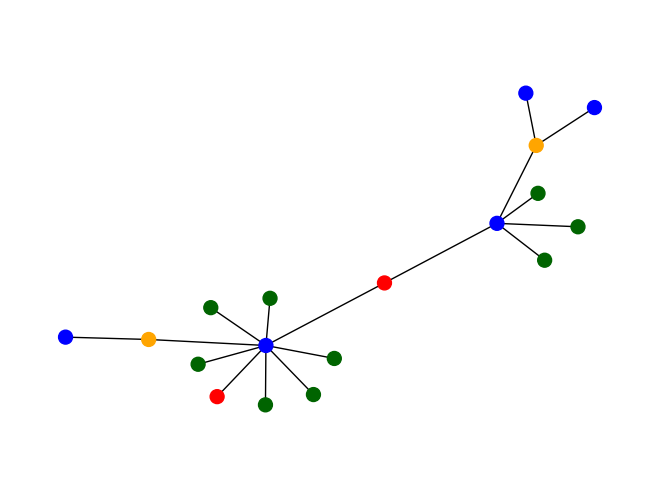

In [51]:
explanation_graph0 = plot_graph(class0_nodeid, max_pred0, 0, all_edges[class0_nodeid])

In [34]:
ind= index_2d(softmax_dict[class0_nodeid], max_pred0)[0]

In [35]:
list0= nodefeature_dict[class0_nodeid]['author'].numpy()[ind]

In [36]:
Counter(list0)

Counter({0.0: 328, 1.0: 6})

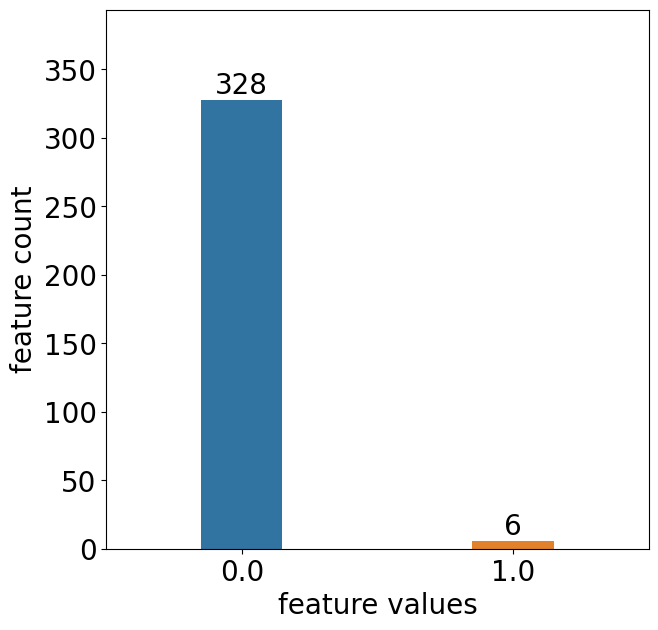

In [79]:
count_plot(list0)

Number of nodes:  29
nodeid for generating 2 hop graph:  1416
Max pred probability for class 1 is 0.9961510896682739


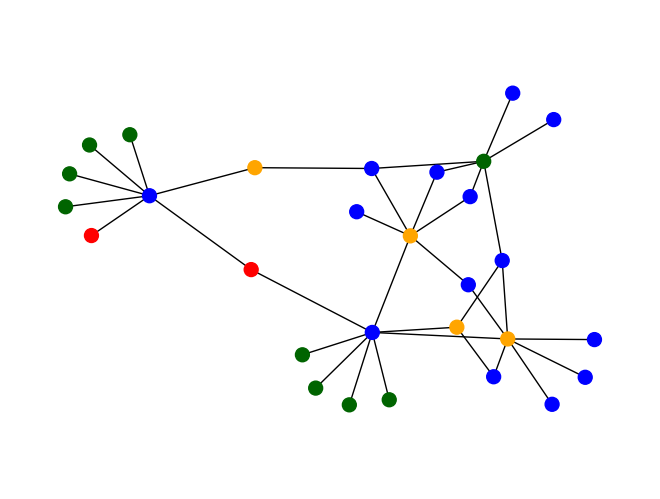

In [58]:
explanation_graph1 = plot_graph(class1_nodeid, max_pred1, 1,all_edges[class1_nodeid])

In [39]:
ind= index_2d(softmax_dict[class1_nodeid], max_pred1)[0]

In [40]:
list1= nodefeature_dict[class1_nodeid]['author'].numpy()[ind]

In [41]:
Counter(list1)

Counter({0.0: 325, 1.0: 9})

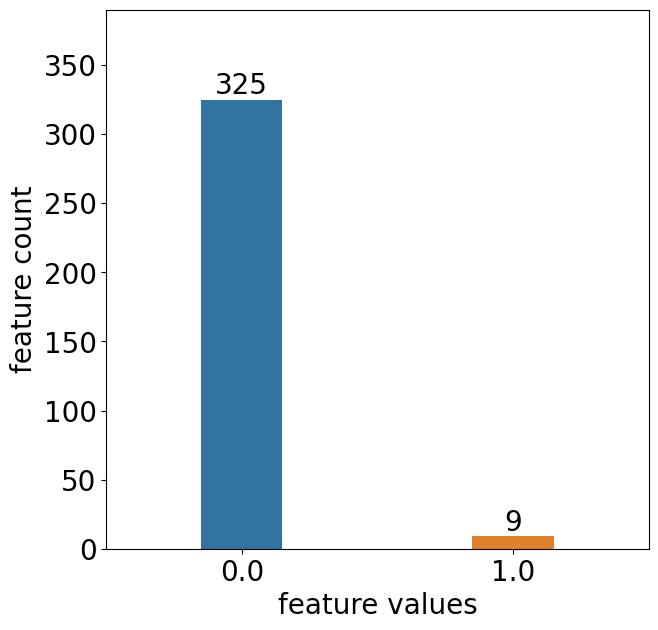

In [80]:
count_plot(list1)

Number of nodes:  13
nodeid for generating 2 hop graph:  3288
Max pred probability for class 2 is 0.997624933719635


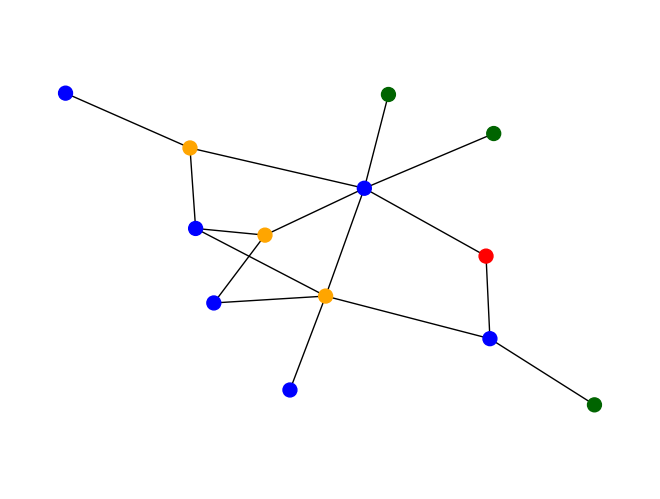

In [57]:
explanation_graph2 = plot_graph(class2_nodeid, max_pred2, 2,all_edges[class2_nodeid])

In [44]:
ind= index_2d(softmax_dict[class2_nodeid], max_pred2)[0]

In [45]:
list2= nodefeature_dict[class2_nodeid]['author'].numpy()[ind]

In [46]:
Counter(list2)

Counter({0.0: 325, 1.0: 9})

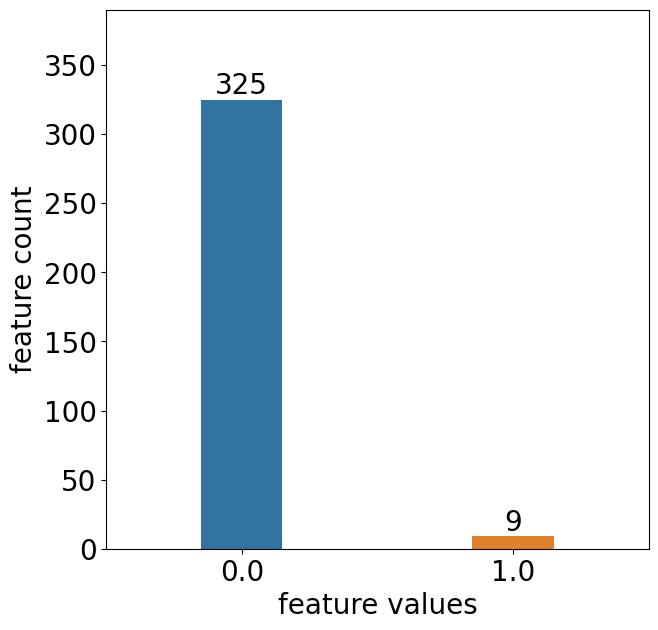

In [81]:
count_plot(list2)

Number of nodes:  16
nodeid for generating 2 hop graph:  155
Max pred probability for class 3 is 0.9987502098083496


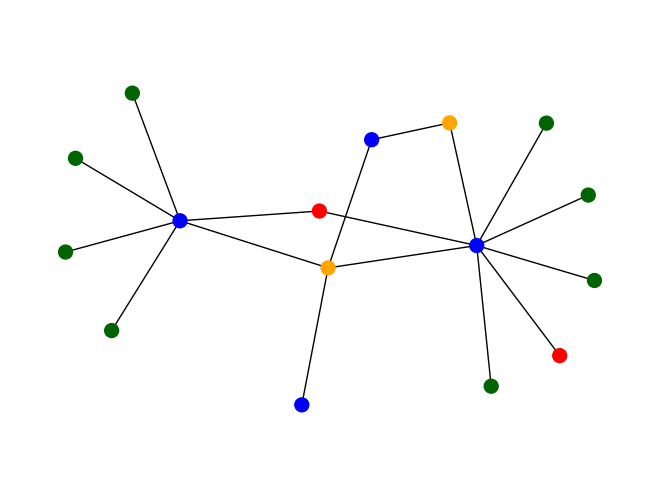

In [48]:
explanation_graph3 = plot_graph(class3_nodeid, max_pred3, 3, all_edges[class3_nodeid])

In [49]:
ind= index_2d(softmax_dict[class3_nodeid], max_pred3)[0]

list3= nodefeature_dict[class3_nodeid]['author'].numpy()[ind]

In [52]:
Counter(list3)

Counter({0.0: 326, 1.0: 8})

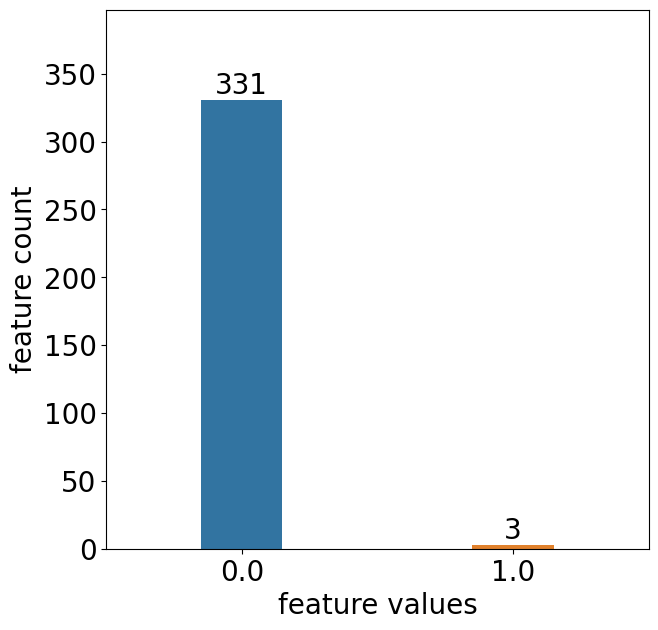

In [82]:
count_plot(list3)

In [60]:
def print_stat_cont_features(df):
    #print('summary',df.describe())
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [61]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

In [62]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [63]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['term'].numpy())
print_stat_cont_features(term0_df)

mean 0.018544918
std dev 0.72799706


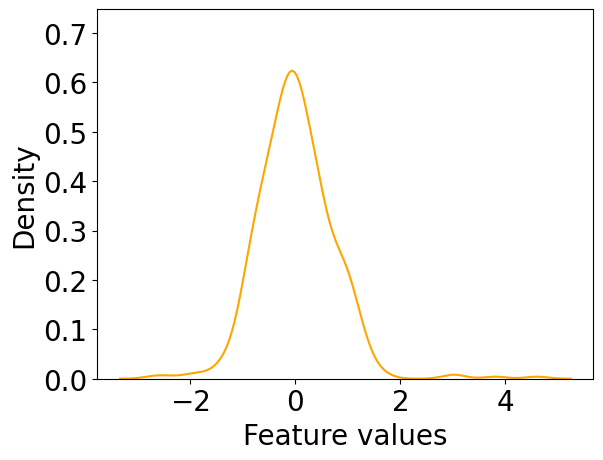

In [64]:
plot_node_feat(term0_df)

In [65]:
term1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['term'].numpy())
print_stat_cont_features(term1_df)

mean -0.0028029506
std dev 0.7484035


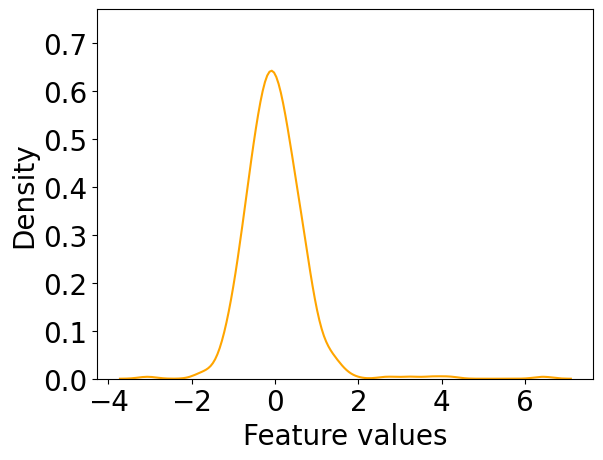

In [66]:
plot_node_feat(term1_df)

In [67]:
term2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['term'].numpy())
print_stat_cont_features(term2_df)

mean 0.050886557
std dev 0.6249864


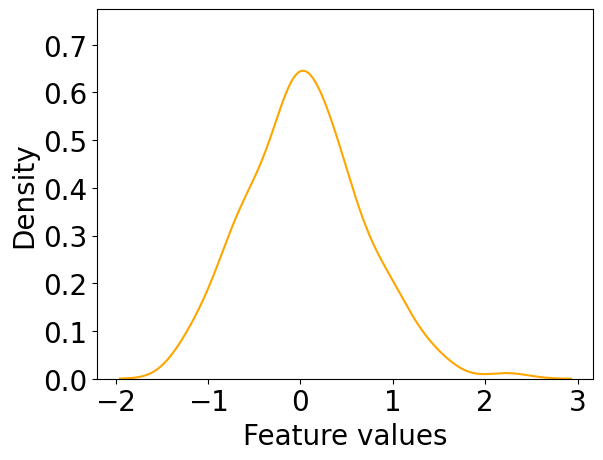

In [68]:
plot_node_feat(term2_df)

In [69]:
term3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['term'].numpy())
print_stat_cont_features(term3_df)

mean 0.020757323
std dev 0.6367199


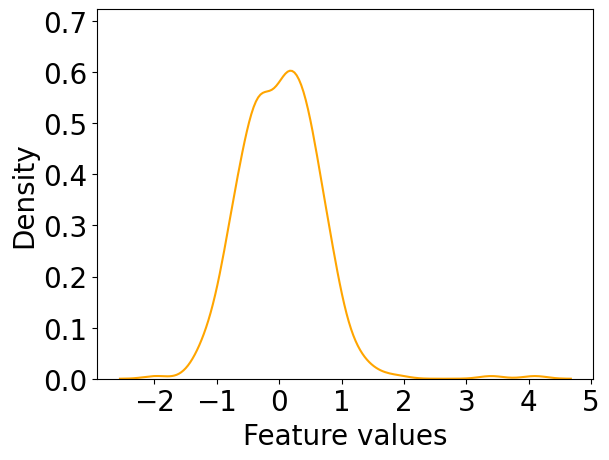

In [70]:
plot_node_feat(term3_df)

In [71]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['paper'].numpy())

In [72]:
imp_paper_feat0=feature_selection(paper0_df)

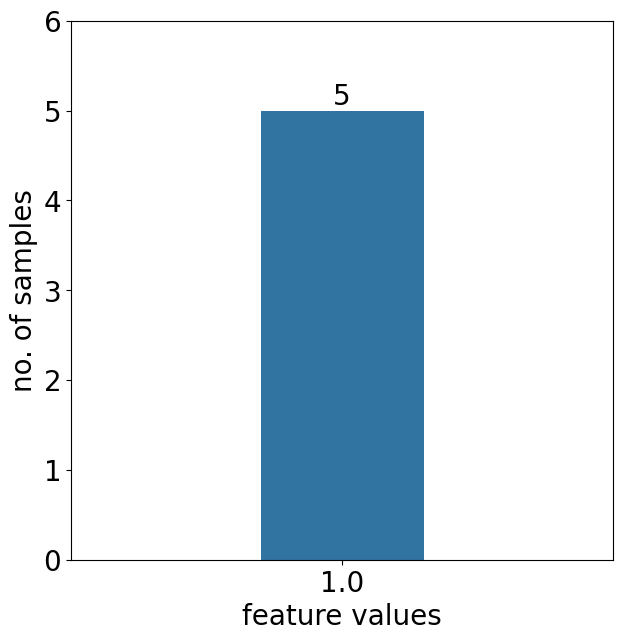

In [86]:
plot_imp_feature(imp_paper_feat0.values.tolist())

In [74]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['paper'].numpy())

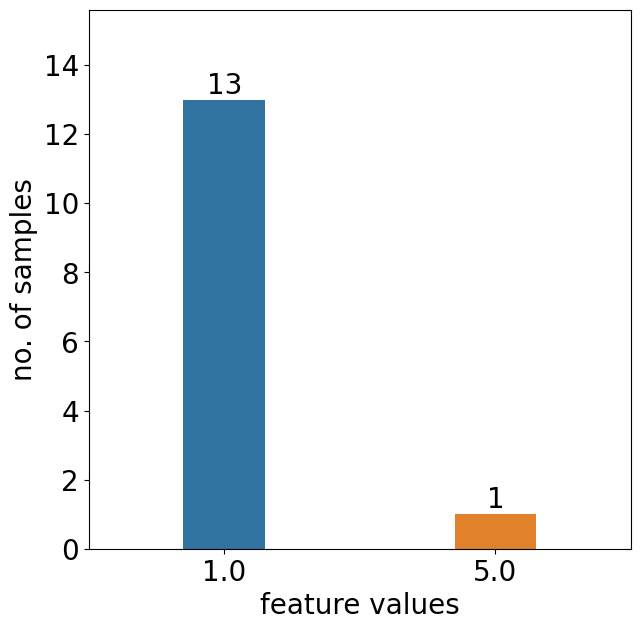

In [87]:
imp_paper_feat1=feature_selection(paper1_df)
plot_imp_feature(imp_paper_feat1.values.tolist())

In [76]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['paper'].numpy())

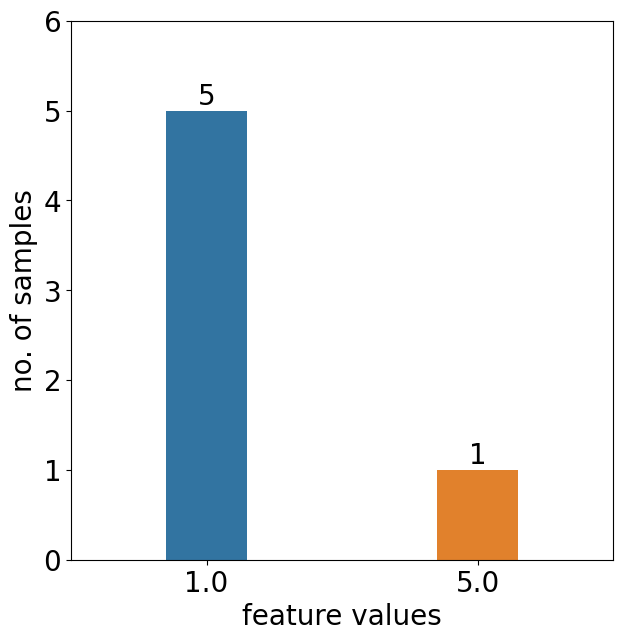

In [88]:
imp_paper_feat2=feature_selection(paper2_df)
plot_imp_feature(imp_paper_feat2.values.tolist())

In [90]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['paper'].numpy())

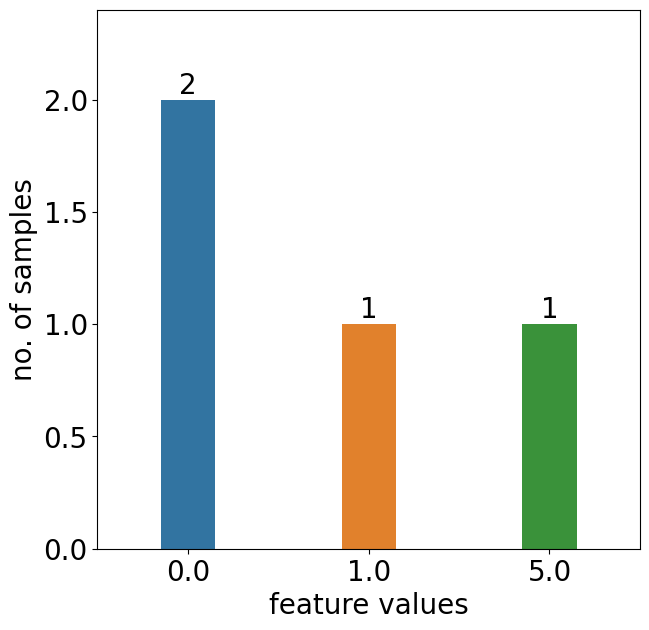

In [91]:
imp_paper_feat3=feature_selection(paper3_df)
plot_imp_feature(imp_paper_feat3.values.tolist())